In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
from time import time
import spacy
import logging
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [4]:
df=pd.read_csv("IRAhandle_tweets_1.csv")
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [5]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)


In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['content'])

In [7]:
#t = time()

#txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

#print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [8]:
df_clean = pd.DataFrame({'clean': brief_cleaning})
df_clean.shape


(243891, 1)

In [9]:
sent = [row.split() for row in df_clean['clean']]

In [10]:
phrases = Phrases(sent, min_count=30, progress_per=10000)


INFO - 12:39:30: collecting all words and their counts
INFO - 12:39:30: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:39:31: PROGRESS: at sentence #10000, processed 148296 words and 115304 word types
INFO - 12:39:32: PROGRESS: at sentence #20000, processed 280346 words and 200559 word types
INFO - 12:39:32: PROGRESS: at sentence #30000, processed 461400 words and 290712 word types
INFO - 12:39:33: PROGRESS: at sentence #40000, processed 651163 words and 349007 word types
INFO - 12:39:34: PROGRESS: at sentence #50000, processed 760360 words and 400085 word types
INFO - 12:39:34: PROGRESS: at sentence #60000, processed 945592 words and 498399 word types
INFO - 12:39:35: PROGRESS: at sentence #70000, processed 1103971 words and 580856 word types
INFO - 12:39:35: PROGRESS: at sentence #80000, processed 1248160 words and 645511 word types
INFO - 12:39:36: PROGRESS: at sentence #90000, processed 1356302 words and 691111 word types
INFO - 12:39:37: PROGRESS: at senten

In [11]:
bigram = Phraser(phrases)

INFO - 12:39:46: source_vocab length 1717307
INFO - 12:40:26: Phraser built with 2990 phrasegrams


In [12]:
sentences = bigram[sent]

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

358590

In [17]:
sorted(word_freq, key=word_freq.get, reverse=True)[16:40]

['trump',
 'you',
 's',
 'it',
 'that',
 'with',
 'at',
 'this',
 'are',
 'all',
 'not',
 'by',
 'my',
 'your',
 'amp',
 'from',
 'e',
 'just',
 'u',
 'as',
 'be',
 'w',
 'we',
 'm']

In [12]:
cores = multiprocessing.cpu_count()
cores

8

In [44]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [19]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

NameError: name 'w2v_model' is not defined

In [46]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 00:35:50: training model with 7 workers on 12524 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 00:35:51: EPOCH 1 - PROGRESS: at 10.43% examples, 130181 words/s, in_qsize 1, out_qsize 0
INFO - 00:35:52: EPOCH 1 - PROGRESS: at 21.76% examples, 144636 words/s, in_qsize 0, out_qsize 0
INFO - 00:35:53: EPOCH 1 - PROGRESS: at 32.40% examples, 147247 words/s, in_qsize 0, out_qsize 1
INFO - 00:35:54: EPOCH 1 - PROGRESS: at 43.28% examples, 151609 words/s, in_qsize 0, out_qsize 0
INFO - 00:35:55: EPOCH 1 - PROGRESS: at 52.00% examples, 155189 words/s, in_qsize 1, out_qsize 0
INFO - 00:35:56: EPOCH 1 - PROGRESS: at 63.52% examples, 155990 words/s, in_qsize 0, out_qsize 0
INFO - 00:35:57: EPOCH 1 - PROGRESS: at 75.64% examples, 154694 words/s, in_qsize 0, out_qsize 0
INFO - 00:35:58: EPOCH 1 - PROGRESS: at 87.07% examples, 153750 words/s, in_qsize 0, out_qsize 1
INFO - 00:35:59: EPOCH 1 - PROGRESS: at 98.30% examples, 154020 words/s, in_qsize 0, out_

INFO - 00:36:44: EPOCH 6 - PROGRESS: at 31.98% examples, 107367 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:45: EPOCH 6 - PROGRESS: at 42.19% examples, 116508 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:46: EPOCH 6 - PROGRESS: at 49.96% examples, 122368 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:47: EPOCH 6 - PROGRESS: at 60.05% examples, 126659 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:48: EPOCH 6 - PROGRESS: at 71.41% examples, 129640 words/s, in_qsize 0, out_qsize 1
INFO - 00:36:49: EPOCH 6 - PROGRESS: at 83.07% examples, 130764 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:50: EPOCH 6 - PROGRESS: at 93.19% examples, 131856 words/s, in_qsize 0, out_qsize 0
INFO - 00:36:50: worker thread finished; awaiting finish of 6 more threads
INFO - 00:36:51: worker thread finished; awaiting finish of 5 more threads
INFO - 00:36:51: worker thread finished; awaiting finish of 4 more threads
INFO - 00:36:51: worker thread finished; awaiting finish of 3 more threads
INFO - 00:36:51: work

INFO - 00:37:38: EPOCH 11 - PROGRESS: at 66.39% examples, 135827 words/s, in_qsize 0, out_qsize 0
INFO - 00:37:39: EPOCH 11 - PROGRESS: at 76.37% examples, 134838 words/s, in_qsize 0, out_qsize 0
INFO - 00:37:40: EPOCH 11 - PROGRESS: at 86.78% examples, 134730 words/s, in_qsize 0, out_qsize 0
INFO - 00:37:41: EPOCH 11 - PROGRESS: at 97.00% examples, 135125 words/s, in_qsize 0, out_qsize 0
INFO - 00:37:42: worker thread finished; awaiting finish of 6 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 5 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 4 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 3 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 2 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 1 more threads
INFO - 00:37:42: worker thread finished; awaiting finish of 0 more threads
INFO - 00:37:42: EPOCH - 11 : training on 3638618 raw words (1435436 effective word

INFO - 00:38:31: worker thread finished; awaiting finish of 3 more threads
INFO - 00:38:31: worker thread finished; awaiting finish of 2 more threads
INFO - 00:38:31: worker thread finished; awaiting finish of 1 more threads
INFO - 00:38:31: worker thread finished; awaiting finish of 0 more threads
INFO - 00:38:31: EPOCH - 16 : training on 3638618 raw words (1434797 effective words) took 9.9s, 145316 effective words/s
INFO - 00:38:32: EPOCH 17 - PROGRESS: at 10.93% examples, 140999 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:33: EPOCH 17 - PROGRESS: at 22.22% examples, 146789 words/s, in_qsize 1, out_qsize 0
INFO - 00:38:34: EPOCH 17 - PROGRESS: at 33.37% examples, 147939 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:35: EPOCH 17 - PROGRESS: at 43.05% examples, 150100 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:36: EPOCH 17 - PROGRESS: at 51.55% examples, 152877 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:37: EPOCH 17 - PROGRESS: at 62.41% examples, 153095 words/s, in_qsize 0, ou

INFO - 00:39:22: EPOCH 22 - PROGRESS: at 30.47% examples, 136674 words/s, in_qsize 0, out_qsize 0
INFO - 00:39:23: EPOCH 22 - PROGRESS: at 41.34% examples, 140867 words/s, in_qsize 0, out_qsize 0
INFO - 00:39:24: EPOCH 22 - PROGRESS: at 49.50% examples, 144886 words/s, in_qsize 0, out_qsize 1
INFO - 00:39:25: EPOCH 22 - PROGRESS: at 59.09% examples, 146295 words/s, in_qsize 0, out_qsize 0
INFO - 00:39:26: EPOCH 22 - PROGRESS: at 70.97% examples, 147447 words/s, in_qsize 0, out_qsize 0
INFO - 00:39:27: EPOCH 22 - PROGRESS: at 82.86% examples, 146643 words/s, in_qsize 0, out_qsize 0
INFO - 00:39:28: EPOCH 22 - PROGRESS: at 94.90% examples, 148011 words/s, in_qsize 1, out_qsize 0
INFO - 00:39:29: worker thread finished; awaiting finish of 6 more threads
INFO - 00:39:29: worker thread finished; awaiting finish of 5 more threads
INFO - 00:39:29: worker thread finished; awaiting finish of 4 more threads
INFO - 00:39:29: worker thread finished; awaiting finish of 3 more threads
INFO - 00:39:2

INFO - 00:40:17: EPOCH 27 - PROGRESS: at 89.13% examples, 139536 words/s, in_qsize 11, out_qsize 2
INFO - 00:40:17: worker thread finished; awaiting finish of 6 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 5 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 4 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 3 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 2 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 1 more threads
INFO - 00:40:17: worker thread finished; awaiting finish of 0 more threads
INFO - 00:40:17: EPOCH - 27 : training on 3638618 raw words (1435605 effective words) took 9.8s, 146072 effective words/s
INFO - 00:40:18: EPOCH 28 - PROGRESS: at 10.93% examples, 140468 words/s, in_qsize 0, out_qsize 0
INFO - 00:40:19: EPOCH 28 - PROGRESS: at 22.22% examples, 147744 words/s, in_qsize 0, out_qsize 0
INFO - 00:40:20: EPOCH 28 - PROGRESS: at 31.98% examples, 

Time to train the model: 4.94 mins


In [47]:
w2v_model.init_sims(replace=True)

INFO - 00:40:47: precomputing L2-norms of word weight vectors


In [18]:
w2v_model.wv.most_similar(positive=["trump"])

NameError: name 'w2v_model' is not defined

In [3]:
w2v_model = KeyedVectors.load_word2vec_format(datapath(r"C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin"), binary=True)

INFO - 12:02:58: loading projection weights from C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin
INFO - 12:03:04: loaded (102421, 200) matrix from C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin


In [7]:
w2v_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=10)

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('queen', 0.5467880964279175),
 ('kings', 0.47554317116737366),
 ('legend', 0.4600725769996643),
 ('first_lady', 0.4459725618362427),
 ('david', 0.4430624842643738),
 ('princess', 0.4338906407356262),
 ('king’s', 0.43005168437957764),
 ('president', 0.4281637668609619),
 ('champion', 0.4280173182487488),
 ('king_jr', 0.4190962314605713)]

In [3]:
w2v_model.wv.most_similar(positive=["donald", "man"], negative=["woman"], topn=10)

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
INFO - 14:31:25: precomputing L2-norms of word weight vectors


[('donald_trump', 0.577904462814331),
 ('realdonaldtrump', 0.5481843948364258),
 ('trump', 0.5224006772041321),
 ('mr', 0.5032348036766052),
 ('him', 0.4678301215171814),
 ('sir', 0.46452999114990234),
 ('potus', 0.453476220369339),
 ('president_trump', 0.4518176317214966),
 ('so', 0.45052385330200195),
 ('president', 0.4472476840019226)]

In [9]:
w2v_model.wv.most_similar(positive=["donald", "woman"], negative=["man"], topn=10)

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('donald_trump', 0.5900172591209412),
 ('realdonaldtrump', 0.5558092594146729),
 ('trump', 0.532914936542511),
 ('hillary', 0.5144106149673462),
 ('michelle_obama', 0.49386894702911377),
 ('president_trump', 0.4921758770942688),
 ('hillaryclinton', 0.4890635013580322),
 ('first_lady', 0.47681814432144165),
 ('hillary_clinton', 0.47592997550964355),
 ('potus', 0.47388508915901184)]

In [10]:
w2v_model.wv.doesnt_match(["trump", "clinton", "obama"]) #odd one out

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Rajnish\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'clinton'

In [11]:
w2v_model.wv.vectors.shape

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(102421, 200)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 200), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 21 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


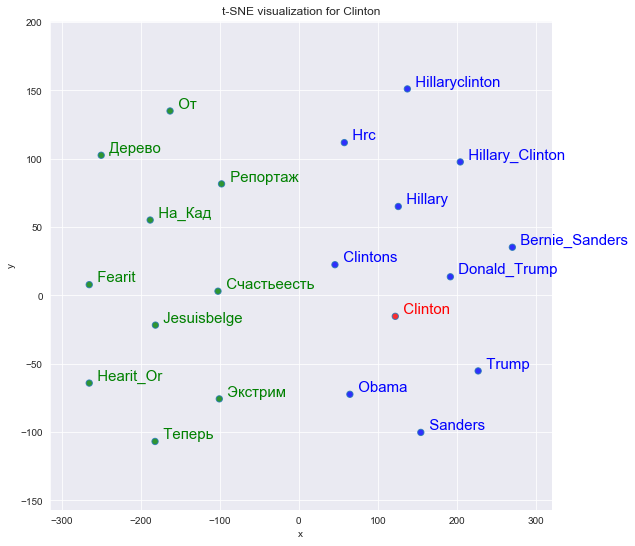

In [18]:
tsnescatterplot(w2v_model, 'clinton', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


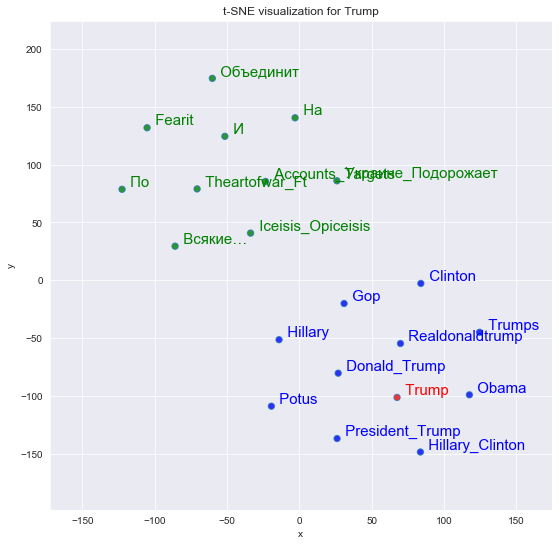

In [19]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


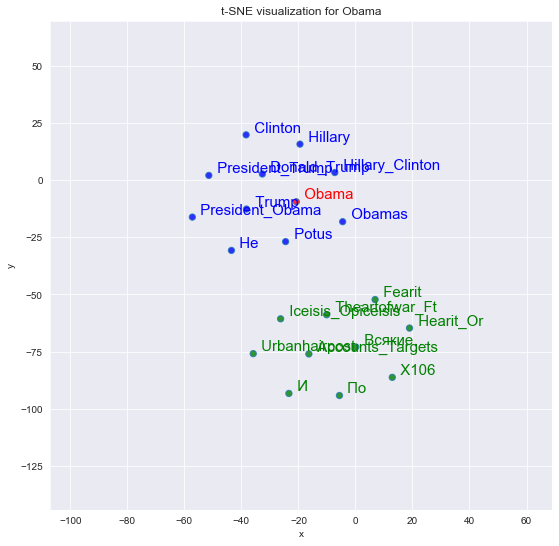

In [20]:
tsnescatterplot(w2v_model, 'obama', [i[0] for i in w2v_model.wv.most_similar(negative=["obama"])])

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


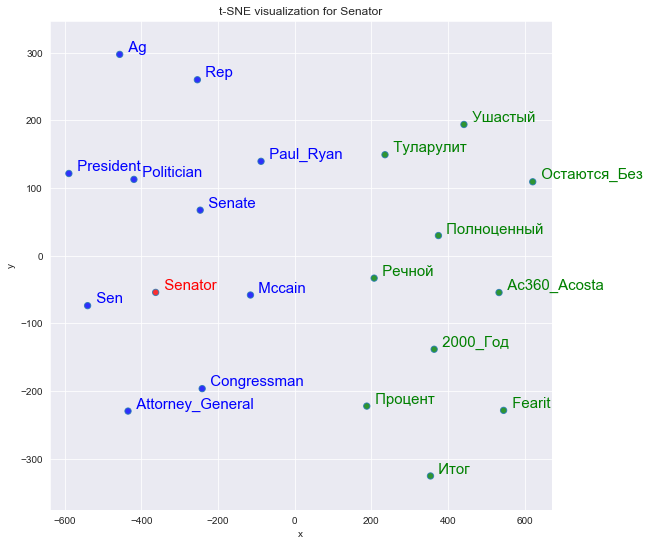

In [21]:
tsnescatterplot(w2v_model, 'senator', [i[0] for i in w2v_model.wv.most_similar(negative=["senator"])])

In [16]:
import numpy as np
word_labels = ['donald_trump']
model=w2v_model
arrays = np.empty((0, 200), dtype='f')
list_names=[i[0] for i in w2v_model.wv.most_similar(positive=["donald_trump"])]
for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        #color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
word_labels

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


['donald_trump',
 'trump',
 'hillary_clinton',
 'president_trump',
 'obama',
 'realdonaldtrump',
 'bernie_sanders',
 'hillary',
 'donaldtrump',
 'ted_cruz',
 'clinton']

In [62]:
#w2v_model.wv.save_word2vec_format('model.bin', binary=True)

INFO - 00:41:40: storing 12524x200 projection weights into model.bin


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
words_ak = []
embeddings_ak = []
for word in list(w2v_model.wv.vocab):
    embeddings_ak.append(w2v_model.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Cluster of the words in our Vocab', embeddings_ak_2d, a=0.1)

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [24]:
df[df['language'] == 'Russian']


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
372,2528776985,1488REASONS,Причина #67 Мутко: «Зенит-Арене» для адаптации...,Unknown,Russian,1/19/2017 13:07,1/19/2017 13:07,6311,6313,1806,...,Russian,0,NonEnglish,0,2528776985,822067907547066368,http://twitter.com/2528776985/statuses/8220679...,NaN,NaN,NaN
373,2528776985,1488REASONS,Причина #70 Житель Самары умер в очереди в пол...,Unknown,Russian,1/22/2017 12:37,4/5/2017 7:17,1580,6298,1869,...,Russian,0,NonEnglish,0,2528776985,823147583895994368,http://twitter.com/2528776985/statuses/8231475...,NaN,NaN,NaN
374,2528776985,1488REASONS,Причина #74 Президентский советник предложил о...,Unknown,Russian,1/26/2017 15:39,1/26/2017 15:40,6305,6312,1813,...,Russian,0,NonEnglish,0,2528776985,824643054351085568,http://twitter.com/2528776985/statuses/8246430...,NaN,NaN,NaN
375,2528776985,1488REASONS,Причина #75 Казаков благословили на защиту инт...,Unknown,Russian,1/27/2017 13:23,1/27/2017 13:23,6304,6311,1814,...,Russian,0,NonEnglish,0,2528776985,824971050161209344,http://twitter.com/2528776985/statuses/8249710...,NaN,NaN,NaN
376,2528776985,1488REASONS,Причина #77 В Кстово полицейские сломали женщи...,Unknown,Russian,1/29/2017 11:07,1/29/2017 11:30,6306,6308,1816,...,Russian,0,NonEnglish,0,2528776985,825661520726089728,http://twitter.com/2528776985/statuses/8256615...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242397,2446391643,ATULSCARPA,"'@zubovnik и останутся пассивы, доведя её до п...",United States,Russian,7/16/2015 23:35,7/16/2015 23:38,729,797,2795,...,Russian,0,NonEnglish,1,2446391643,621825618330693632,http://twitter.com/AtulScarpa/statuses/6218256...,NaN,NaN,NaN
242398,2446391643,ATULSCARPA,'@NovostiEkb вот это - дело!',United States,Russian,8/24/2015 19:11,9/20/2015 14:06,198,688,2836,...,Russian,0,NonEnglish,1,2446391643,635892251701420032,http://twitter.com/AtulScarpa/statuses/6358922...,NaN,NaN,NaN
242399,2446391643,ATULSCARPA,Пойдет ли Запад на 4 условия Путина? http://t...,United States,Russian,9/28/2015 14:34,9/28/2015 14:34,196,644,2891,...,Russian,1,NonEnglish,1,2446391643,648506011179974656,http://twitter.com/AtulScarpa/statuses/6485060...,https://twitter.com/zubovnik/status/6485038780...,http://boeing-is-back.livejournal.com/339835.html,NaN
242400,2446391643,ATULSCARPA,Немного хорошей пародии на тему блокады Крыма ...,United States,Russian,9/29/2015 13:15,9/29/2015 13:17,196,642,2892,...,Russian,0,NonEnglish,1,2446391643,648848596251623425,http://twitter.com/AtulScarpa/statuses/6488485...,https://www.youtube.com/watch?v=Q-PvYtQ9GWU&fe...,NaN,NaN


In [25]:
w2v_model.wv.most_similar('doctor', topn=10)

NameError: name 'w2v_model' is not defined

In [36]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
wv_from_bin = KeyedVectors.load_word2vec_format(datapath(r"C:\Users\Rajnish\Desktop\Assignment 4\model.bin"), binary=True)

INFO - 13:03:47: loading projection weights from C:\Users\Rajnish\Desktop\Assignment 4\model.bin
INFO - 13:03:47: loaded (12524, 200) matrix from C:\Users\Rajnish\Desktop\Assignment 4\model.bin


In [45]:
wv_from_bin.wv.similarity('president','he')

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


0.41568547

In [71]:
wv_from_bin.wv.similarity('barack_obama','genuine')
wv_from_bin.wv.similarity('donald_trump','genuine')

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


0.087333575